In [141]:
import pandas as pd
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from UKMovementSensing import hsmm

In [143]:
execfile('config.py')

## Load data

In [144]:
# Import data with states
filenames = os.listdir(states_path_model)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(states_path_model,fn))]
datasets = [pd.read_csv(os.path.join(states_path_model,fn), encoding='utf-8', index_col='timestamp', parse_dates=True) for fn in filenames]

print(len(datasets))

38


In [145]:
#Concatenate all data together for analysis
all_data = pd.concat(datasets)

In [146]:
#Define consistent colormap
from matplotlib.colors import LinearSegmentedColormap
# One more than the number of states, so we have a color for 'All'
nr_states = all_data.state.nunique()
colormap, cmap = hsmm.get_color_map(nr_states+1)
cmap_states = LinearSegmentedColormap.from_list('name',
                                             [colormap[i] for i in range(nr_states)],
                                             nr_states)

In [147]:
activities_simplified = pd.read_csv(activities_simplified_path, header=0, sep=',', dtype=str)
levelmap = {'0': "low", '1': "high", '2':"mixed"}
def get_category_des(motion, arm_changes):
    return levelmap[motion]+" motion, " + levelmap[arm_changes] + " arm changes"
activities_simplified['simplified_category'] = [get_category_des(row[1], row[2]) for row in activities_simplified.get_values()]
activities_simplified.head()

,Label,"Locomotion (no=0,yes=1,unclear=2)","Frequent arm angle changes (no=0,yes=1,unclear=2)",SUM,Keep variable,Behavioural category,simplified_category
0,Sleeping and resting (including sick in bed),0,0,0,TRUE,0,"low motion, low arm changes"
1,"Did nothing, just relaxing, bored, waiting",0,0,0,TRUE,0,"low motion, low arm changes"
2,"Watch TV, DVDs, downloaded videos",0,0,0,TRUE,0,"low motion, low arm changes"
3,Eating a meal,0,1,1,TRUE,1,"low motion, high arm changes"
4,Reading (not for school),0,1,1,TRUE,1,"low motion, high arm changes"


In [148]:
all_data = all_data.merge(activities_simplified, left_on='act_label', right_on='Label', how='left')

## Calculate per-state statistics

In [149]:
bystate = all_data.groupby('state')
means = bystate[column_names].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

In [150]:
#Now for all columns
bystate = all_data.groupby('state')
means = bystate[all_data.columns].mean().transpose()
means.style.background_gradient(cmap='coolwarm',axis=1)

## Cross table activity - state

Let's compare the states with the known activities. First we have look at how many 5-seconds frame we have for each state/activity, and we sort from largest to smallest

In [151]:
ctab = pd.crosstab(all_data['act_label'], all_data['state'], margins=True).sort_values('All', ascending=False)

In [152]:
all_data_sub = all_data[all_data['Keep variable']=='TRUE']
ctab_simplified = pd.crosstab(all_data_sub['simplified_category'], all_data_sub['state'], 
                              margins=True).sort_values('All', ascending=False)
ctab_simplified

state,0,1,2,3,All
simplified_category,,,,,
All,110669,90278,137543,29610,368100
"low motion, low arm changes",50802,48233,65767,12738,177540
"low motion, mixed arm changes",31939,28923,44671,6547,112080
"high motion, high arm changes",11149,5087,7868,4996,29100
"low motion, high arm changes",7135,4705,9783,2617,24240
"mixed motion, high arm changes",6018,2384,3547,1911,13860
"mixed motion, low arm changes",3626,946,5907,801,11280


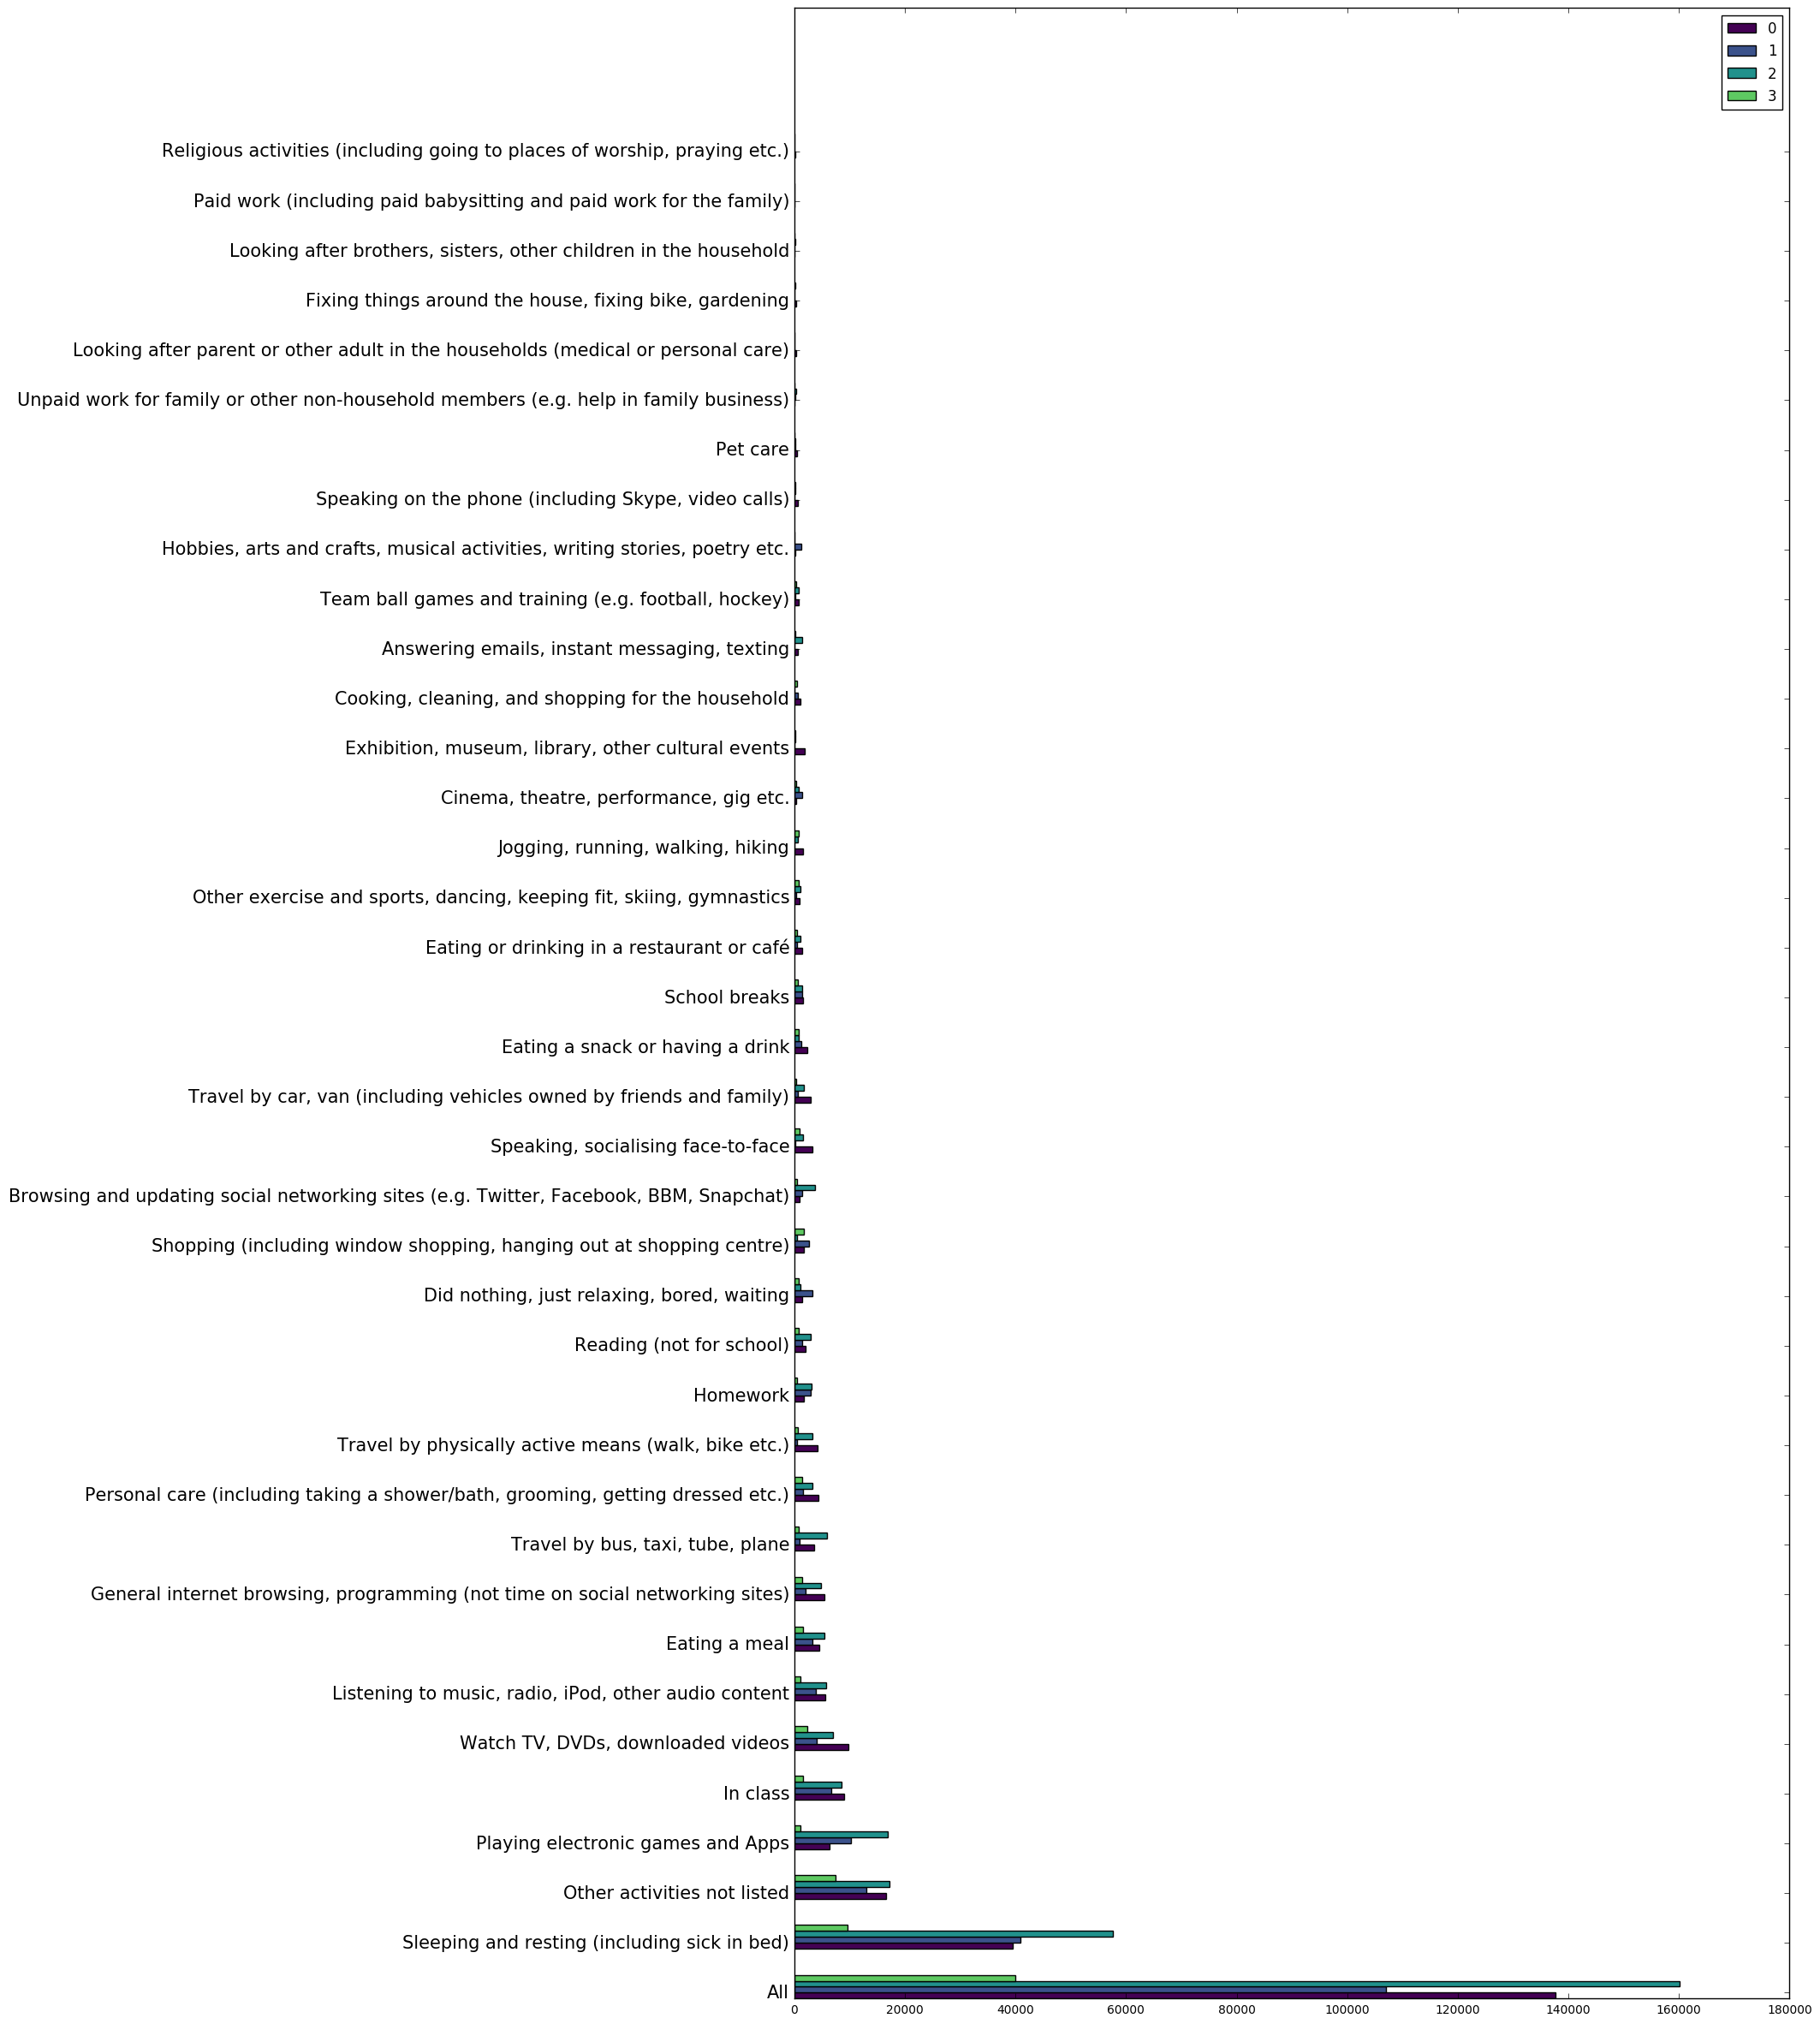

In [153]:
from __future__ import unicode_literals
fig, ax = plt.subplots(figsize=(15,30))

states = ctab.columns
acts = ctab.index

n_groups = len(acts)
index = len(states)*np.arange(n_groups)
bar_width = 1./len(states)*3
colors = colormap

#Draw all states, but don't draw All
for i in range(len(states)-1):
    rects1 = plt.barh(index + i*bar_width, 
                     ctab[states[i]], 
                     bar_width,
                     color=colors[i],
                     label=states[i])

plt.yticks(index + bar_width, ctab.index, fontsize=15)
plt.legend()

#Set maximum to something reasonable, namely the maximum of not-all
#ax.set_xlim(0, ctab[states[-1]][acts[1]])
plt.show()

In [154]:
#Now normalize over the activity and sort by total number
data = all_data_sub
label = 'simplified_category' #'act_label'
ind = list(ctab_simplified.index)
ctab_norm1 = pd.crosstab(data[label], data['state'], normalize='index', margins=True).loc[ind]

In [155]:
ctab_norm1.style.background_gradient(cmap='BuGn',axis=1)

In [156]:
#Now normalize over state and sort by total number
#ind = list(ctab.index)
ctab_norm2 = pd.crosstab(all_data[label], all_data['state'], normalize='columns', margins=True).loc[ind]
ctab_norm2 = ctab_norm2.fillna(0)

In [157]:
ctab_norm2.style.background_gradient(cmap='BuGn',axis=0)

Check if there is a significant correlation between the states and the activities:

In [158]:
topactivities = 10 # take most frequent activities
counts = ctab.as_matrix()[1:1+topactivities,:-1]
chi2, p, dof, expected = scipy.stats.chi2_contingency(counts)
print(chi2, p)

15498.6268713 0.0


## States for an example sequence

In [159]:
example_index = 2
data = datasets[example_index]
hidden_states = data['state']

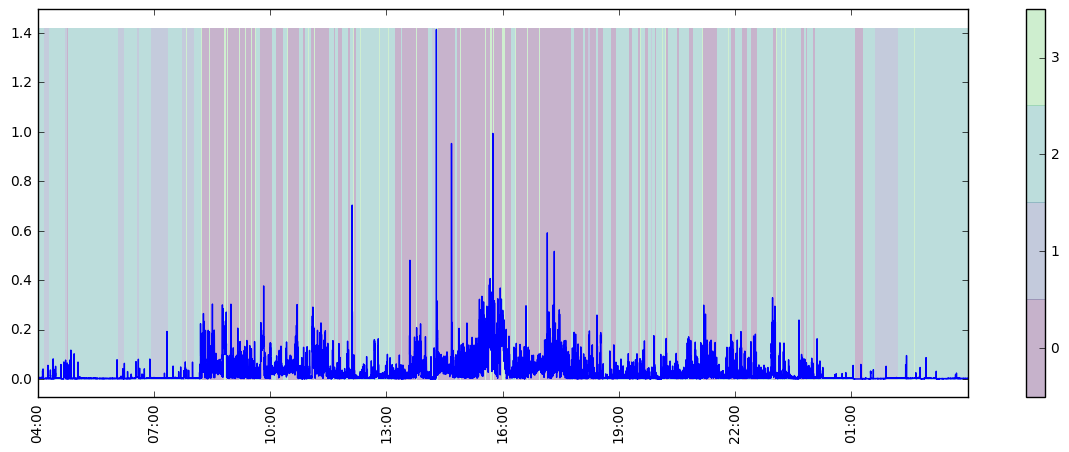

In [177]:
hsmm.plot_states_and_var_new(data, hidden_states, columns=['acceleration',], by='act', cmap=cmap_states)

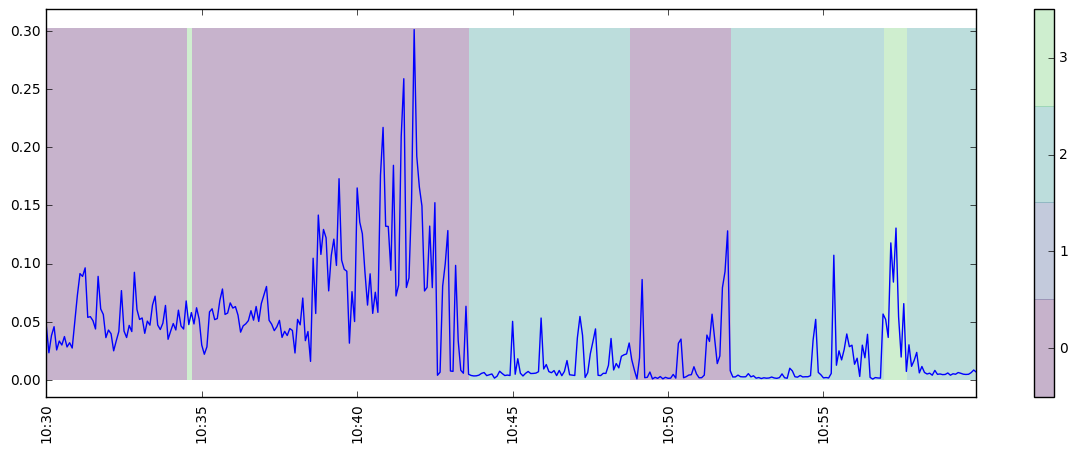

In [176]:
start =int(6.5*12*60)
end = 7*12*60
hsmm.plot_states_and_var_new(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['acceleration'], by='act')

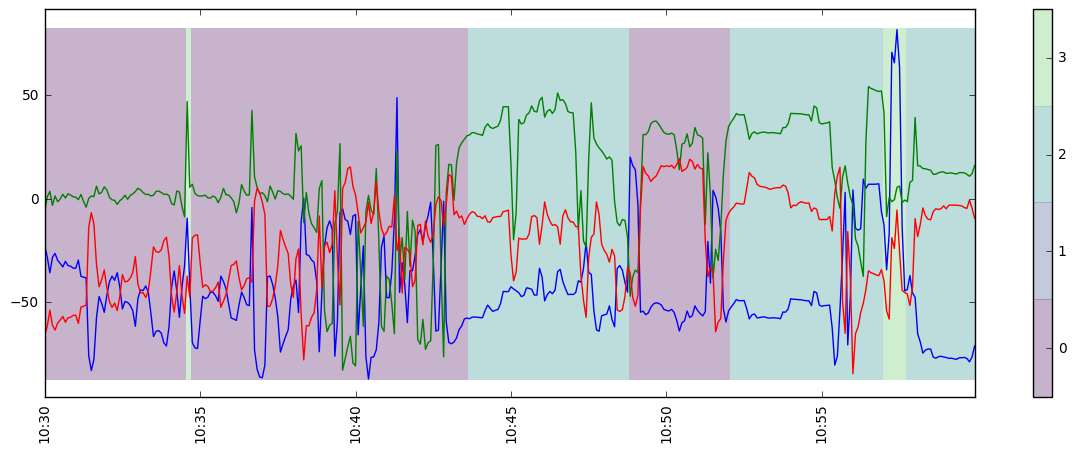

In [178]:
hsmm.plot_states_and_var_new(data[start:end], hidden_states[start:end], cmap=cmap_states, columns=['anglex', 'angley', 'anglez'], by='act')